## Ploting changes in observation before and after data imputation.
## Some stats of data

In [1]:
#Importing libraries 
import pandas as pd
import numpy as np
import imageio
import warnings
import os
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# h = .02  # step size in the mesh
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import scikitplot as skplt
from sklearn.model_selection import GridSearchCV
import math
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import matplotlib.lines as mlines
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns 
from scipy import interp
from itertools import cycle
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA as sklearnPCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
# mpl.style.use('seaborn-colorblind')
mpl.style.use('default')
warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

In [2]:
#Keeping the directory correct
os.chdir('C:\\Users\\Vipul Satone\\health data') # default directory
address = 'C:\\Users\\Vipul Satone\\health data\\ADNI\\final_code\\commented code\\github results\\github_drive\\github\\niips\\thesis\\fig_24\\' # directory where images are to be stored
# Inside this folder (m24_m12) have a folder gif. Inside this folder have three different folders named ica, pca, nmf.

In [3]:
# assessment data
cols = {}
list_months_to_be_considered = ['bl','m06','m12']

In [4]:
# Following function gives information about dataset to be imputed.
def data_info(dataset, name):
    print('\n\n')
    print('***********************************************')
    print('Name of dataset is: ' + name) 
    print('\n0th level of columns is {}'.format(list(pd.Series(dataset.columns.get_level_values(0)).unique()) ) )
    try:
        print('\n1st level of columns is: {}'.format(list(pd.Series(dataset.columns.get_level_values(1)).unique()))  )
    except:
        pass
    print('\nShape of datset is: {}'.format(dataset.shape ) )
    print('\nTotal number of missing values: {}'.format(dataset.isnull().sum().sum()) )
    print('***********************************************')
    print('\n\n')

In [5]:
def visualize_unclean_data(Train):
    null_in_cols = Train.isnull().sum()
    null_in_rows = Train.isnull().sum(axis = 1)
    print(Train.isnull().sum().sum())
    if (null_in_cols.sum() != 0):
        fig_1 = plt.figure()
        arr = plt.hist(null_in_rows , bins=np.arange(round(min(null_in_rows)), round(max(null_in_rows)) + null_in_rows.max()/8,null_in_rows.max()/8))
        plt.xlabel('count of features having NULL in them')
        plt.ylabel('Number of observations (that have *bin* \n number of features NULL in them)')
        plt.title('Graph to find out number of most empty observations \n (max null values can be %d)(Rows)' %(Train.shape[1]))
        for i in range(len(arr[0])):
            if (arr[0][i] != 0):
                plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
        fig_1.show()

        fig_2 = plt.figure()
        arr1 = plt.hist(null_in_cols, bins=np.arange(round(min(null_in_cols)), round(max(null_in_cols)) + null_in_cols.max()/8,null_in_cols.max()/8))
        plt.xlabel('count of observations having NULL in them')
        plt.ylabel('Number of features (that have *bin* \n number of observations NULL in them)')
        plt.title('Graph to find out number of most empty features \n (max null values can be %d)(Columns)' %(Train.shape[0]))
        for i in range(len(arr1[0])):
            if (arr1[0][i] != 0):
                plt.text(arr1[1][i],arr1[0][i],str(arr1[0][i]))
        fig_2.show()

In [6]:
# Argument Train1 is dta to be normalized. IF argument b is 'z' the z normalization is done otherwise minmax normalization is done.
def normalize(Train1,b):
    col_names = list(Train1.columns)
    if (b == 'z'):
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - Train1[col_names[i]].mean(skipna = True)) / Train1[col_names[i]].std(skipna = True)
    else:
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - min(Train1[col_names[i]]) )/ ( max(Train1[col_names[i]] ) - min(Train1[col_names[i]]) )
    return Train1

#### Data imputation

In [7]:
#CDR
cols['cdr'] = ['RID','VISCODE2', 'CDMEMORY', 'CDORIENT', 'CDJUDGE' ,'CDCOMMUN' ,'CDHOME' ,'CDCARE']
cdr = pd.read_csv("ADNI\\Raw_Data\\Assessment\\CDR.csv",index_col='RID', usecols=cols['cdr'])
cdr1 = cdr.copy(deep = True)
cdr = cdr[cdr['VISCODE2'].isin(['bl','m12','m06']) ]  
cdr = cdr.reset_index().set_index(['RID','VISCODE2'])
cdr = cdr[~cdr.index.duplicated()].unstack()
cdr = cdr[ (cdr.isnull().sum(axis = 1) <= 4) ]
cdr = cdr.T
cdr = cdr[cdr.index.get_level_values(1).isin(list_months_to_be_considered)].T
cdr2 = cdr.copy(deep = True)
# reducing index level
cdr_ruf = cdr.T.reset_index()
cdr_ruf.iloc[:,0]  = 'cdr__' + cdr_ruf.iloc[:,0] +  '___' + cdr_ruf.iloc[:,1]
cdr_ruf = cdr_ruf.set_index('level_0')
cdr = cdr_ruf.iloc[:,1:].T
cdr_no_encoding = cdr
data_info(cdr,'Clinical Dementia Rating')




***********************************************
Name of dataset is: Clinical Dementia Rating

0th level of columns is ['cdr__CDMEMORY___m06', 'cdr__CDMEMORY___m12', 'cdr__CDORIENT___m06', 'cdr__CDORIENT___m12', 'cdr__CDJUDGE___m06', 'cdr__CDJUDGE___m12', 'cdr__CDCOMMUN___m06', 'cdr__CDCOMMUN___m12', 'cdr__CDHOME___m06', 'cdr__CDHOME___m12', 'cdr__CDCARE___m06', 'cdr__CDCARE___m12']

Shape of datset is: (1461, 12)

Total number of missing values: 0
***********************************************





In [8]:
#NEUROBAT - Just using the total scores CLCOKSCOR, COPYSCOR, BNTTOTAL
cols['neurobat'] = ['RID', 'VISCODE2', 'CLOCKSCOR', 'COPYSCOR', 'LMSTORY', 'LIMMTOTAL', 'LIMMEND',
       'AVTOT1', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3', 'AVERR3', 'AVTOT4',
       'AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB',
       'AVENDED', 'DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH',
       'CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS',
       'CATVGINTR', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR',
       'TRABERRCOM', 'TRABERROM', 'DIGITSCOR', 'LDELBEGIN', 'LDELTOTAL',
       'LDELCUE','BNTTOTAL', 'AVDELBEGAN', 'AVDEL30MIN', 'AVDELERR1',
       'AVDELTOT', 'AVDELERR2', 'ANARTND', 'ANARTERR']
neurobat_1 = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat'], index_col = ['RID', 'VISCODE2'])
cols['neurobat_clock'] = ['RID', 'VISCODE2', 'CLOCKSCOR']
neurobat_clock = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_clock'], index_col = ['RID', 'VISCODE2'])
neurobat_clock1 = neurobat_clock.copy(deep = True) 
neurobat_clock = neurobat_clock[~neurobat_clock.index.duplicated()].reset_index()
neurobat_clock = neurobat_clock[neurobat_clock.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_clock = neurobat_clock.unstack()
neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_clock = neurobat_clock.columns.levels[0]
for a in new_col_list_neurobat_clock: 
    neurobat_clock[a] = neurobat_clock[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_clock.name = 'Neuropsychological Battery (subdata - clock)'
#data_info(neurobat_clock)

cols['neurobat_copy'] = ['RID', 'VISCODE2', 'COPYSCOR']
neurobat_copy = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_copy'], index_col = ['RID', 'VISCODE2'])
neurobat_copy1 = neurobat_copy.copy(deep = True) 
neurobat_copy = neurobat_copy[~neurobat_copy.index.duplicated()].reset_index()
neurobat_copy = neurobat_copy[neurobat_copy.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_copy = neurobat_copy.unstack()
neurobat_copy = neurobat_copy[ (neurobat_copy.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_copy = neurobat_copy.columns.levels[0]
for a in new_col_list_neurobat_copy: 
    neurobat_copy[a] = neurobat_copy[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_copy.name = 'Neuropsychological Battery (subdata - copy)'
#data_info(neurobat_copy)

cols['neurobat_limm_story'] = ['RID', 'VISCODE2', 'LIMMTOTAL']
neurobat_limm_story = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_limm_story'], index_col = ['RID', 'VISCODE2'])
neurobat_limm_story1 = neurobat_limm_story.copy(deep = True) 
neurobat_limm_story = neurobat_limm_story[~neurobat_limm_story.index.duplicated()].reset_index()
neurobat_limm_story = neurobat_limm_story[neurobat_limm_story.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_limm_story = neurobat_limm_story.unstack()
neurobat_limm_story = neurobat_limm_story.drop(['m06','bl'], axis=1, level=1)
#neurobat_limm_story = neurobat_limm_story.T[ (neurobat_limm_story.columns.levels[1]) == 'm12' ].T
neurobat_limm_story = neurobat_limm_story[ (neurobat_limm_story.isnull().sum(axis = 1) < 1) ]
neurobat_limm_story.name = 'Neuropsychological Battery (subdata - story)'
#data_info(neurobat_limm_story)

cols['neurobat_dspan'] = ['RID', 'VISCODE2','DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH']
neurobat_dspan = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_dspan'], index_col = ['RID', 'VISCODE2'])
neurobat_dspan1 = neurobat_dspan.copy(deep = True) 
neurobat_dspan = neurobat_dspan[~neurobat_dspan.index.duplicated()].reset_index()
neurobat_dspan = neurobat_dspan[neurobat_dspan.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) < 4) ]
neurobat_dspan = neurobat_dspan.unstack()
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_dspan = neurobat_dspan.columns.levels[0]
for a in new_col_list_neurobat_dspan: 
    neurobat_dspan[a] = neurobat_dspan[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_dspan.name = 'Neuropsychological Battery (subdata - digit span)'
#data_info(neurobat_dspan)

cols['neurobat_cat_flu'] = ['RID', 'VISCODE2','CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS','CATVGINTR']
neurobat_cat_flu = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_cat_flu'], index_col = ['RID', 'VISCODE2'])
neurobat_cat_flu1 = neurobat_cat_flu.copy(deep = True) 
neurobat_cat_flu = neurobat_cat_flu[~neurobat_cat_flu.index.duplicated()].reset_index()
neurobat_cat_flu = neurobat_cat_flu[neurobat_cat_flu.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_cat_flu = neurobat_cat_flu.replace({-1: np.NAN})
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) < 4) ]
del neurobat_cat_flu['CATVEGESC']
del neurobat_cat_flu['CATVGPERS']
del neurobat_cat_flu['CATVGINTR']
neurobat_cat_flu = neurobat_cat_flu.unstack()
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) <4) ]
new_col_list_neurobat_cat_flu = neurobat_cat_flu.columns.levels[0]
for a in new_col_list_neurobat_cat_flu: 
    neurobat_cat_flu[a] = neurobat_cat_flu[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_cat_flu.name = 'Neuropsychological Battery (subdata - category fluency : only animal examples)'
#data_info(neurobat_cat_flu)

cols['neurobat_trail'] = ['RID', 'VISCODE2', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR','TRABERRCOM', 'TRABERROM']
neurobat_trail = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_trail'], index_col = ['RID', 'VISCODE2'])
neurobat_trail1 = neurobat_trail.copy(deep = True) 
neurobat_trail = neurobat_trail[~neurobat_trail.index.duplicated()].reset_index()
neurobat_trail = neurobat_trail[neurobat_trail.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) < 3) ]
neurobat_trail = neurobat_trail.unstack()
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) <=6) ]
new_col_list_neurobat_trail = neurobat_trail.columns.levels[0]
for a in new_col_list_neurobat_trail: 
    neurobat_trail[a] = neurobat_trail[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_trail.name = 'Neuropsychological Battery (subdata - Trail making)'
#data_info(neurobat_trail)

cols['neurobat_av'] = ['RID', 'VISCODE2','AVTOT1', 'AVDELERR1','AVDELTOT', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3',     'AVERR3','AVDELERR2', 'AVTOT4','AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB','AVDEL30MIN']
neurobat_av = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_av'], index_col = ['RID', 'VISCODE2'])
neurobat_av1 = neurobat_av.copy(deep = True) 
neurobat_av = neurobat_av[~neurobat_av.index.duplicated()].reset_index()
neurobat_av = neurobat_av[neurobat_av.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_av = neurobat_av.unstack()
neurobat_av = neurobat_av[ (neurobat_av.isnull().sum(axis = 1) <25) ]
new_col_list_neurobat_av = neurobat_av.columns.levels[0]
for a in new_col_list_neurobat_av: 
    neurobat_av[a] = neurobat_av[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_av.name = 'Neuropsychological Battery (subdata - av)'
#data_info(neurobat_av)

cols['neurobat_digit_score'] = ['RID', 'VISCODE2','DIGITSCOR']
neurobat_digit_score = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_digit_score'], index_col = ['RID', 'VISCODE2'])
neurobat_digit_score1 = neurobat_digit_score.copy(deep = True) 
neurobat_digit_score = neurobat_digit_score[~neurobat_digit_score.index.duplicated()].reset_index()
neurobat_digit_score = neurobat_digit_score[neurobat_digit_score.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_digit_score = neurobat_digit_score.unstack()
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_digit_score = neurobat_digit_score.columns.levels[0]
for a in new_col_list_neurobat_digit_score: 
    neurobat_digit_score[a] = neurobat_digit_score[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_digit_score.name = 'Neuropsychological Battery (subdata - digit score)'
#data_info(neurobat_digit_score)

cols['neurobat_logical_memory'] = ['RID', 'VISCODE2','LDELTOTAL']
neurobat_logical_memory = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_logical_memory'], index_col = ['RID', 'VISCODE2'])
neurobat_logical_memory1 = neurobat_logical_memory.copy(deep = True) 
neurobat_logical_memory = neurobat_logical_memory[~neurobat_logical_memory.index.duplicated()].reset_index()
neurobat_logical_memory = neurobat_logical_memory[neurobat_logical_memory.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_logical_memory = neurobat_logical_memory[ (neurobat_logical_memory.isnull().sum(axis = 1) < 1) ]
neurobat_logical_memory = neurobat_logical_memory.unstack()
neurobat_logical_memory.name = 'Neuropsychological Battery (subdata - logical memeory test)'
#data_info(neurobat_logical_memory)

cols['neurobat_boston_naming_test'] = ['RID', 'VISCODE2', 'BNTSPONT','BNTSTIM','BNTCSTIM','BNTPHON','BNTCPHON']
neurobat_boston_naming_test = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_boston_naming_test'], index_col = ['RID', 'VISCODE2'])
neurobat_boston_naming_test1 = neurobat_boston_naming_test.copy(deep = True) 
neurobat_boston_naming_test = neurobat_boston_naming_test[~neurobat_boston_naming_test.index.duplicated()].reset_index()
neurobat_boston_naming_test = neurobat_boston_naming_test[neurobat_boston_naming_test.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) < 5) ]
neurobat_boston_naming_test = neurobat_boston_naming_test.unstack()
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_boston_naming_test = neurobat_boston_naming_test.columns.levels[0]
for a in new_col_list_neurobat_boston_naming_test: 
    neurobat_boston_naming_test[a] = neurobat_boston_naming_test[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_boston_naming_test.name = 'Neuropsychological Battery (subdata - Boston naming test)'
#data_info(neurobat_boston_naming_test)

cols['neurobat_anrt'] = ['RID', 'VISCODE2', 'ANARTND']
neurobat_anrt = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_anrt'], index_col = ['RID', 'VISCODE2'])
neurobat_anrt1 = neurobat_anrt.copy(deep = True) 
neurobat_anrt = neurobat_anrt[~neurobat_anrt.index.duplicated()].reset_index()
neurobat_anrt = neurobat_anrt[neurobat_anrt.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_anrt = neurobat_anrt.unstack()
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_anrt = neurobat_anrt.columns.levels[0]
for a in new_col_list_neurobat_anrt: 
    neurobat_anrt[a] = neurobat_anrt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_anrt.name = 'Neuropsychological Battery (subdata - American national reading test)'
#data_info(neurobat_anrt)


# neurobat1 = pd.merge(neurobat_clock1,neurobat_copy1 , left_index = True, right_index = True, how='inner')
# neurobat1 = pd.merge(neurobat1,neurobat_limm_story1 , left_index = True, right_index = True, how='inner')
# neurobat1 = pd.merge(neurobat1,neurobat_av1 , left_index = True, right_index = True, how='inner')
# neurobat1 = pd.merge(neurobat1,neurobat_cat_flu1 , left_index = True, right_index = True, how='inner')
# neurobat1 = pd.merge(neurobat1,neurobat_trail1 , left_index = True, right_index = True, how='inner')
# neurobat1 = pd.merge(neurobat1,neurobat_logical_memory1 , left_index = True, right_index = True, how='inner')
# neurobat1 = pd.merge(neurobat1,neurobat_boston_naming_test1 , left_index = True, right_index = True, how='inner')
# neurobat1 = neurobat1.T
# neurobat1 = neurobat1[neurobat1.index.get_level_values(1).isin(list_months_to_be_considered)].T


neurobat2 = pd.merge(neurobat_clock,neurobat_copy , left_index = True, right_index = True, how='inner')
neurobat2 = pd.merge(neurobat2,neurobat_limm_story , left_index = True, right_index = True, how='inner')
neurobat2 = pd.merge(neurobat2,neurobat_av , left_index = True, right_index = True, how='inner')
neurobat2 = pd.merge(neurobat2,neurobat_cat_flu , left_index = True, right_index = True, how='inner')
neurobat2 = pd.merge(neurobat2,neurobat_trail , left_index = True, right_index = True, how='inner')
neurobat2 = pd.merge(neurobat2,neurobat_logical_memory , left_index = True, right_index = True, how='inner')
neurobat2 = pd.merge(neurobat2,neurobat_boston_naming_test , left_index = True, right_index = True, how='inner')
neurobat2 = neurobat2.T
neurobat2 = neurobat2[neurobat2.index.get_level_values(1).isin(list_months_to_be_considered)].T
neurobat3 = neurobat2.copy(deep = True) 

# reducing index level
neurobat2_ruf = neurobat2.T.reset_index()
neurobat2_ruf.iloc[:,0]  = 'neurobat__' + neurobat2_ruf.iloc[:,0] +  '___' + neurobat2_ruf.iloc[:,1]
neurobat2_ruf = neurobat2_ruf.set_index('level_0')
neurobat2 = neurobat2_ruf.iloc[:,1:].T
neurobat2_no_encoding = neurobat2
neurobat = neurobat2


data_info(neurobat,'Neuropsychological Battery (All combined)')





***********************************************
Name of dataset is: Neuropsychological Battery (All combined)

0th level of columns is ['neurobat__CLOCKSCOR___bl', 'neurobat__CLOCKSCOR___m06', 'neurobat__CLOCKSCOR___m12', 'neurobat__COPYSCOR___bl', 'neurobat__COPYSCOR___m06', 'neurobat__COPYSCOR___m12', 'neurobat__LIMMTOTAL___m12', 'neurobat__AVTOT1___bl', 'neurobat__AVTOT1___m06', 'neurobat__AVTOT1___m12', 'neurobat__AVERR1___bl', 'neurobat__AVERR1___m06', 'neurobat__AVERR1___m12', 'neurobat__AVTOT2___bl', 'neurobat__AVTOT2___m06', 'neurobat__AVTOT2___m12', 'neurobat__AVERR2___bl', 'neurobat__AVERR2___m06', 'neurobat__AVERR2___m12', 'neurobat__AVTOT3___bl', 'neurobat__AVTOT3___m06', 'neurobat__AVTOT3___m12', 'neurobat__AVERR3___bl', 'neurobat__AVERR3___m06', 'neurobat__AVERR3___m12', 'neurobat__AVTOT4___bl', 'neurobat__AVTOT4___m06', 'neurobat__AVTOT4___m12', 'neurobat__AVERR4___bl', 'neurobat__AVERR4___m06', 'neurobat__AVERR4___m12', 'neurobat__AVTOT5___bl', 'neurobat__AVTOT5___m0

In [9]:
#MMSE
cols['mmse'] = ['RID', 'VISCODE2','MMSCORE']
mmse = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MMSE.csv', usecols=cols['mmse'], index_col = ['RID', 'VISCODE2'])
mmse1 = mmse.copy(deep = True)
mmse = mmse[~mmse.index.duplicated()].reset_index()
mmse = mmse[mmse.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
mmse = mmse.replace({-4:np.NAN})
mmse = mmse.replace({-1:np.NAN})
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 10) ]
mmse = mmse.unstack()
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 20) ]
mmse = mmse[~mmse.index.duplicated()]
mmse = mmse.T
mmse = mmse[mmse.index.get_level_values(1).isin(list_months_to_be_considered)].T
mmse2 = mmse.copy(deep = True)
# reducing index level
mmse_ruf = mmse.T.reset_index()
mmse_ruf.iloc[:,0]  = 'mmse__' + mmse_ruf.iloc[:,0] +  '___' + mmse_ruf.iloc[:,1]
mmse_ruf = mmse_ruf.set_index('level_0')
mmse = mmse_ruf.iloc[:,1:].T
mmse_no_encoding = mmse
mmse = mmse_no_encoding    
data_info(mmse,'Mini Mental State Exam')




***********************************************
Name of dataset is: Mini Mental State Exam

0th level of columns is ['mmse__MMSCORE___m06', 'mmse__MMSCORE___m12']

Shape of datset is: (1641, 2)

Total number of missing values: 192
***********************************************





In [10]:
#GERIATRIC
cols['geriatric'] = ['VISCODE2', 'RID', 'GDTOTAL']
geriatric = pd.read_csv("ADNI\\Raw_Data\\Assessment\\GDSCALE.csv", index_col='RID', usecols=cols['geriatric'])
geriatric1 = geriatric.copy(deep = True)
geriatric = geriatric.replace({-4:np.NAN})
geriatric = geriatric.replace({-1:np.NAN})
geriatric = geriatric[geriatric['VISCODE2'].isin(['bl','m12','m06']) ]  
geriatric = geriatric.reset_index().set_index(['RID','VISCODE2'])
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric[~geriatric.index.duplicated()].unstack()
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric.T
geriatric = geriatric[geriatric.index.get_level_values(1).isin(list_months_to_be_considered)].T
geriatric2 = geriatric.copy(deep = True)
# reducing index level
geriatric_ruf = geriatric.T.reset_index()
geriatric_ruf.iloc[:,0]  = 'gd_scale__' + geriatric_ruf.iloc[:,0] +  '___' + geriatric_ruf.iloc[:,1]
geriatric_ruf = geriatric_ruf.set_index('level_0')
geriatric = geriatric_ruf.iloc[:,1:].T
geriatric_no_encoding = geriatric
data_info(geriatric,'Geriatric depression scale')




***********************************************
Name of dataset is: Geriatric depression scale

0th level of columns is ['gd_scale__GDTOTAL___m06', 'gd_scale__GDTOTAL___m12']

Shape of datset is: (723, 2)

Total number of missing values: 0
***********************************************





In [11]:
#NPI
cols['npi'] = ['RID', 'VISCODE2','NPIATOT', 'NPIBTOT', 'NPICTOT',  'NPIDTOT',     'NPIETOT', 'NPIFTOT', 'NPIGTOT', 'NPIHTOT', 'NPIITOT', 'NPIJTOT','NPIKTOT', 'NPILTOT']
npi = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NPI.csv', usecols=cols['npi'], index_col = ['RID', 'VISCODE2'])
npi1 = npi.copy(deep = True)
npi = npi[~npi.index.duplicated()].reset_index()
# m12 only
npi_m12 = npi[npi.VISCODE2.isin(['m12'])].set_index(['RID','VISCODE2'])
npi_m12 = npi_m12[~npi_m12.index.duplicated()].unstack()
npi_m12 = npi_m12[ (npi_m12.isnull().sum(axis = 1) < 12) ]
# baseline
npi_bl = npi[npi.VISCODE2.isin(['bl'])].set_index(['RID','VISCODE2'])
npi_bl = npi_bl[~npi_bl.index.duplicated()].unstack()
npi_bl = npi_bl[ (npi_bl.isnull().sum(axis = 1) < 12) ]
# both baseline and m12
npi_all = npi[npi.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
npi_all = npi_all[~npi_all.index.duplicated()].unstack()
npi_all = npi_all[ (npi_all.isnull().sum(axis = 1) < 10) ]
npi_all = npi_all.T
npi_all = npi_all[npi_all.index.get_level_values(1).isin(list_months_to_be_considered)].T
npi2 = npi_all.copy(deep = True)
# reducing index level
npi_all_ruf = npi_all.T.reset_index()
npi_all_ruf.iloc[:,0]  = 'npi_all__' + npi_all_ruf.iloc[:,0] +  '___' + npi_all_ruf.iloc[:,1]
npi_all_ruf = npi_all_ruf.set_index('level_0')
npi_all = npi_all_ruf.iloc[:,1:].T
npi_all_no_encoding = npi_all
data_info(npi_all,'Neuro Inventory')




***********************************************
Name of dataset is: Neuro Inventory

0th level of columns is ['npi_all__NPIATOT___bl', 'npi_all__NPIATOT___m12', 'npi_all__NPIBTOT___bl', 'npi_all__NPIBTOT___m12', 'npi_all__NPICTOT___bl', 'npi_all__NPICTOT___m12', 'npi_all__NPIDTOT___bl', 'npi_all__NPIDTOT___m12', 'npi_all__NPIETOT___bl', 'npi_all__NPIETOT___m12', 'npi_all__NPIFTOT___bl', 'npi_all__NPIFTOT___m12', 'npi_all__NPIGTOT___bl', 'npi_all__NPIGTOT___m12', 'npi_all__NPIHTOT___bl', 'npi_all__NPIHTOT___m12', 'npi_all__NPIITOT___bl', 'npi_all__NPIITOT___m12', 'npi_all__NPIJTOT___bl', 'npi_all__NPIJTOT___m12', 'npi_all__NPIKTOT___bl', 'npi_all__NPIKTOT___m12', 'npi_all__NPILTOT___bl', 'npi_all__NPILTOT___m12']

Shape of datset is: (627, 24)

Total number of missing values: 0
***********************************************





In [12]:
#MOCA 
cols['moca'] = ['RID','VISCODE2', 'TRAILS', 'CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN','LION', 'RHINO', 'CAMEL', 'IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4',
       'IMMT1W5', 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3',
       'SERIAL4', 'SERIAL5', 'REPEAT1', 'REPEAT2', 'FFLUENCY', 'ABSTRAN','ABSMEAS', 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5', 'DATE', 'MONTH',
       'YEAR', 'DAY', 'PLACE', 'CITY']
cols['moca_trail_making'] = ['TRAILS']
cols['moca_visuosoconstructional'] = ['CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN']
cols['moca_naming'] = [ 'LION', 'RHINO', 'CAMEL']
cols['moca_immediate_recall'] = [ 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4', 'IMMT1W5']
cols['moca_attention'] = [ 'DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3','SERIAL4', 'SERIAL5']
cols['moca_sen_repetetion'] = ['REPEAT1','REPEAT2']
cols['moca_fluency'] = ['FFLUENCY']
cols['moca_abstraction'] = ['ABSTRAN','ABSMEAS']
cols['moca_delayed_word_recall'] = [ 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5']
cols['moca_orientation'] = [ 'DATE', 'MONTH', 'YEAR', 'DAY', 'PLACE', 'CITY' ]
moca = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MOCA.csv', usecols=cols['moca'], index_col = ['RID', 'VISCODE2'])
moca['moca_trail_making'] = moca[cols['moca_trail_making']].sum(axis=1)
moca['moca_visuosoconstructional'] = moca[cols['moca_visuosoconstructional']].sum(axis=1)
moca['moca_naming'] = moca[cols['moca_naming']].sum(axis = 1)
moca['moca_immediate_recall'] = moca[cols['moca_immediate_recall']].sum(axis=1)
moca['moca_attention'] = moca[cols['moca_attention']].sum(axis=1)
moca['moca_sen_repetetion'] = moca[cols['moca_sen_repetetion']].sum(axis=1)
moca['moca_fluency'] = moca[cols['moca_fluency']].sum(axis=1)
moca['moca_abstraction'] = moca[cols['moca_abstraction']].sum(axis=1)
moca['moca_delayed_word_recall'] = moca[cols['moca_delayed_word_recall']].sum(axis=1)
moca['moca_orientation'] = moca[cols['moca_orientation']].sum(axis=1)
moca = moca[['moca_trail_making', 'moca_visuosoconstructional', 'moca_naming', 'moca_attention', 'moca_immediate_recall','moca_sen_repetetion', 'moca_fluency','moca_abstraction','moca_delayed_word_recall','moca_orientation']] # drop extra
moca1 = moca.copy(deep = True) 
#Dropping the Duplicated Index (Only 1)
moca = moca[~moca.index.duplicated()].reset_index()
moca = moca[moca.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
moca = moca.unstack()
moca = moca[ (moca.isnull().sum(axis = 1) < 15) ]
new_col_list_moca = moca.columns.levels[0]
for a in new_col_list_moca: 
    moca[a] = moca[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
moca = moca.T
moca = moca[moca.index.get_level_values(1).isin(list_months_to_be_considered)].T
moca2 = moca.copy(deep = True)   
# reducing index level
moca_ruf = moca.T.reset_index()
moca_ruf.iloc[:,0]  = 'moca__' + moca_ruf.iloc[:,0] +  '___' + moca_ruf.iloc[:,1]
moca_ruf = moca_ruf.set_index('level_0')
moca = moca_ruf.iloc[:,1:].T
moca_no_encoding = moca
moca = moca_no_encoding
data_info(moca,'Montreal Cognitive Assessment')




***********************************************
Name of dataset is: Montreal Cognitive Assessment

0th level of columns is ['moca__moca_trail_making___bl', 'moca__moca_trail_making___m06', 'moca__moca_trail_making___m12', 'moca__moca_visuosoconstructional___bl', 'moca__moca_visuosoconstructional___m06', 'moca__moca_visuosoconstructional___m12', 'moca__moca_naming___bl', 'moca__moca_naming___m06', 'moca__moca_naming___m12', 'moca__moca_attention___bl', 'moca__moca_attention___m06', 'moca__moca_attention___m12', 'moca__moca_immediate_recall___bl', 'moca__moca_immediate_recall___m06', 'moca__moca_immediate_recall___m12', 'moca__moca_sen_repetetion___bl', 'moca__moca_sen_repetetion___m06', 'moca__moca_sen_repetetion___m12', 'moca__moca_fluency___bl', 'moca__moca_fluency___m06', 'moca__moca_fluency___m12', 'moca__moca_abstraction___bl', 'moca__moca_abstraction___m06', 'moca__moca_abstraction___m12', 'moca__moca_delayed_word_recall___bl', 'moca__moca_delayed_word_recall___m06', 'moca__moc

In [13]:
#FAQ
cols['faq'] = ['RID', 'VISCODE2', 'FAQTOTAL']
faq = pd.read_csv('ADNI\\Raw_Data\\Assessment\\FAQ.csv', usecols=cols['faq'], index_col = ['RID', 'VISCODE2'])
faq1 = faq.copy(deep = True) 
faq = faq[~faq.index.duplicated()].reset_index()
faq = faq[faq.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
faq = faq[~faq.index.duplicated()]
#Unstacking 
faq = faq.unstack()
faq = faq[ (faq.isnull().sum(axis = 1) < 2) ]
new_col_list_faq = faq.columns.levels[0]
for a in new_col_list_faq: 
    faq[a] = faq[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
faq = faq.T
faq = faq[faq.index.get_level_values(1).isin(list_months_to_be_considered)].T
faq2 = faq.copy(deep = True) 
# reducing index level
faq_ruf = faq.T.reset_index()
faq_ruf.iloc[:,0]  = 'FAQ__' + faq_ruf.iloc[:,0] +  '___' + faq_ruf.iloc[:,1]
faq_ruf = faq_ruf.set_index('level_0')
faq = faq_ruf.iloc[:,1:].T
faq_no_encoding = faq  
faq = faq_no_encoding
data_info(faq,'Functional Assessment Questionnaire')




***********************************************
Name of dataset is: Functional Assessment Questionnaire

0th level of columns is ['FAQ__FAQTOTAL___bl', 'FAQ__FAQTOTAL___m06', 'FAQ__FAQTOTAL___m12']

Shape of datset is: (1637, 3)

Total number of missing values: 0
***********************************************





In [14]:
#EXOGPT
cols['ecogpt'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogpt = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ecogpt.csv",index_col='RID', usecols=cols['ecogpt'])
list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogpt_new = pd.DataFrame()
ecogpt1 = ecogpt.copy(deep = True)
ecogpt = ecogpt.replace({9: np.nan })
ecogpt = ecogpt[ecogpt['VISCODE2'].isin(['bl','m12','m06']) ]  
ecogpt = ecogpt.reset_index().set_index(['RID','VISCODE2'])
ecogpt = ecogpt[~ecogpt.index.duplicated()]
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) <= 30) ]
ecogpt = ecogpt.unstack()
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) < 61) ]
new_col_list_ecogpt = ecogpt.columns.levels[0]
for a in new_col_list_ecogpt: 
    ecogpt[a] = ecogpt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
ecogpt = ecogpt.T
ecogpt_bl = ecogpt[ecogpt.index.get_level_values(1).isin(['bl'])]
ecogpt_m06 = ecogpt[ecogpt.index.get_level_values(1).isin(['m06'])]
ecogpt_m12 = ecogpt[ecogpt.index.get_level_values(1).isin(['m12'])]
 
ecogpt_new['memory_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )
ecogpt2 = ecogpt.copy(deep = True)

# reducing index level
ecogpt_ruf = ecogpt_new.T.reset_index()
ecogpt_ruf.iloc[:,0]  = 'ecogpt___'  + ecogpt_ruf.iloc[:,0]
ecogpt_ruf = ecogpt_ruf.set_index(['index'])
ecogpt_ruf = ecogpt_ruf.T
ecogpt_no_encoding = ecogpt_ruf
ecogpt = ecogpt_no_encoding  
ecogpt = ecogpt[ ecogpt.isnull().sum(axis =1) == 0 ]
data_info(ecogpt,'Everyday Cognition Partner')




***********************************************
Name of dataset is: Everyday Cognition Partner

0th level of columns is ['ecogpt___memory_bl', 'ecogpt___lang_bl', 'ecogpt___vis_bl', 'ecogpt___plan_bl', 'ecogpt___org_bl', 'ecogpt___division_bl', 'ecogpt___memory_m06', 'ecogpt___lang_m06', 'ecogpt___vis_m06', 'ecogpt___plan_m06', 'ecogpt___org_m06', 'ecogpt___division_m06', 'ecogpt___memory_m12', 'ecogpt___lang_m12', 'ecogpt___vis_m12', 'ecogpt___plan_m12', 'ecogpt___org_m12', 'ecogpt___division_m12']

Shape of datset is: (846, 18)

Total number of missing values: 0
***********************************************





In [15]:
#EXOGSP
cols['ecogsp'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogsp = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ECOGSP.csv",index_col='RID', usecols=cols['ecogsp'])
list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogsp_new = pd.DataFrame()
ecogsp1 = ecogsp.copy(deep = True)
print(ecogsp1.shape)
ecogsp = ecogsp.replace({9: np.nan })
ecogsp = ecogsp[ecogsp['VISCODE2'].isin(['bl','m12','m06']) ]  
ecogsp = ecogsp.reset_index().set_index(['RID','VISCODE2'])
ecogsp = ecogsp[~ecogsp.index.duplicated()]
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) <= 30) ]
ecogsp = ecogsp.unstack()
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) < 50) ]
new_col_list_ecogsp = ecogsp.columns.levels[0]
for a in new_col_list_ecogsp: 
    ecogsp[a] = ecogsp[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')

ecogsp = ecogsp.T
ecogsp_bl = ecogsp[ecogsp.index.get_level_values(1).isin(['bl'])]
ecogsp_m06 = ecogsp[ecogsp.index.get_level_values(1).isin(['m06'])]
ecogsp_m12 = ecogsp[ecogsp.index.get_level_values(1).isin(['m12'])]
 
ecogsp_new['memory_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )
ecogsp2 = ecogsp.copy(deep = True)

# reducing index level
ecogsp_ruf = ecogsp_new.T.reset_index()
ecogsp_ruf.iloc[:,0]  = 'ecogsp___'  + ecogsp_ruf.iloc[:,0]
ecogsp_ruf = ecogsp_ruf.set_index(['index'])
ecogsp_ruf = ecogsp_ruf.T
ecogsp_no_encoding = ecogsp_ruf 
ecogsp = ecogsp_no_encoding   

ecogsp = ecogsp[ ecogsp.isnull().sum(axis =1) == 0 ]
data_info(ecogsp,'Everyday Cognition - self')

(5463, 40)



***********************************************
Name of dataset is: Everyday Cognition - self

0th level of columns is ['ecogsp___memory_bl', 'ecogsp___lang_bl', 'ecogsp___vis_bl', 'ecogsp___plan_bl', 'ecogsp___org_bl', 'ecogsp___division_bl', 'ecogsp___memory_m06', 'ecogsp___lang_m06', 'ecogsp___vis_m06', 'ecogsp___plan_m06', 'ecogsp___org_m06', 'ecogsp___division_m06', 'ecogsp___memory_m12', 'ecogsp___lang_m12', 'ecogsp___vis_m12', 'ecogsp___plan_m12', 'ecogsp___org_m12', 'ecogsp___division_m12']

Shape of datset is: (835, 18)

Total number of missing values: 0
***********************************************





#### Ploting changes in value before and after imputations

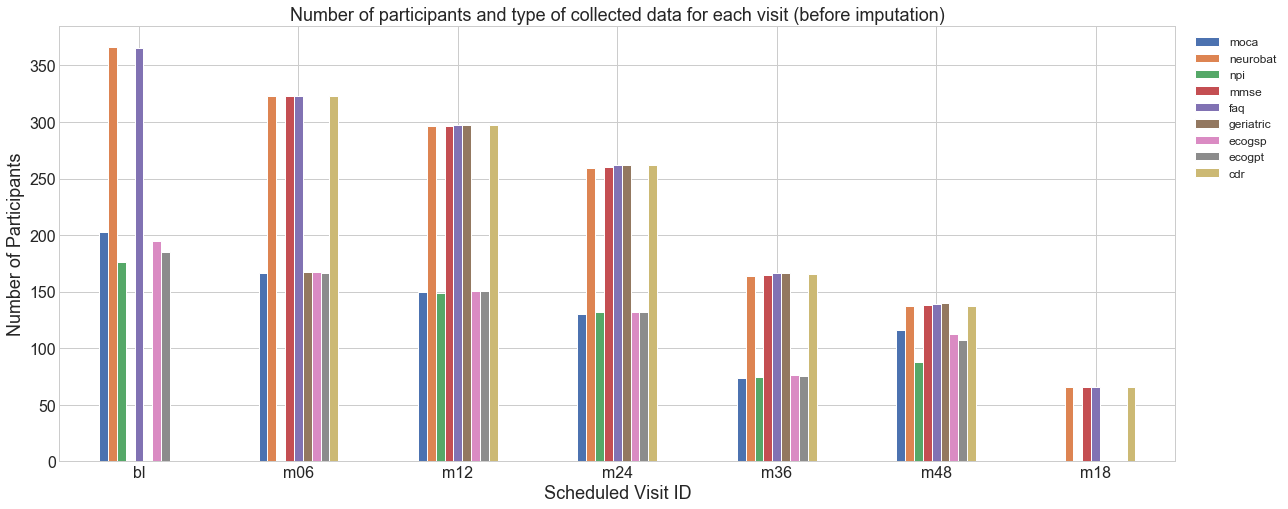

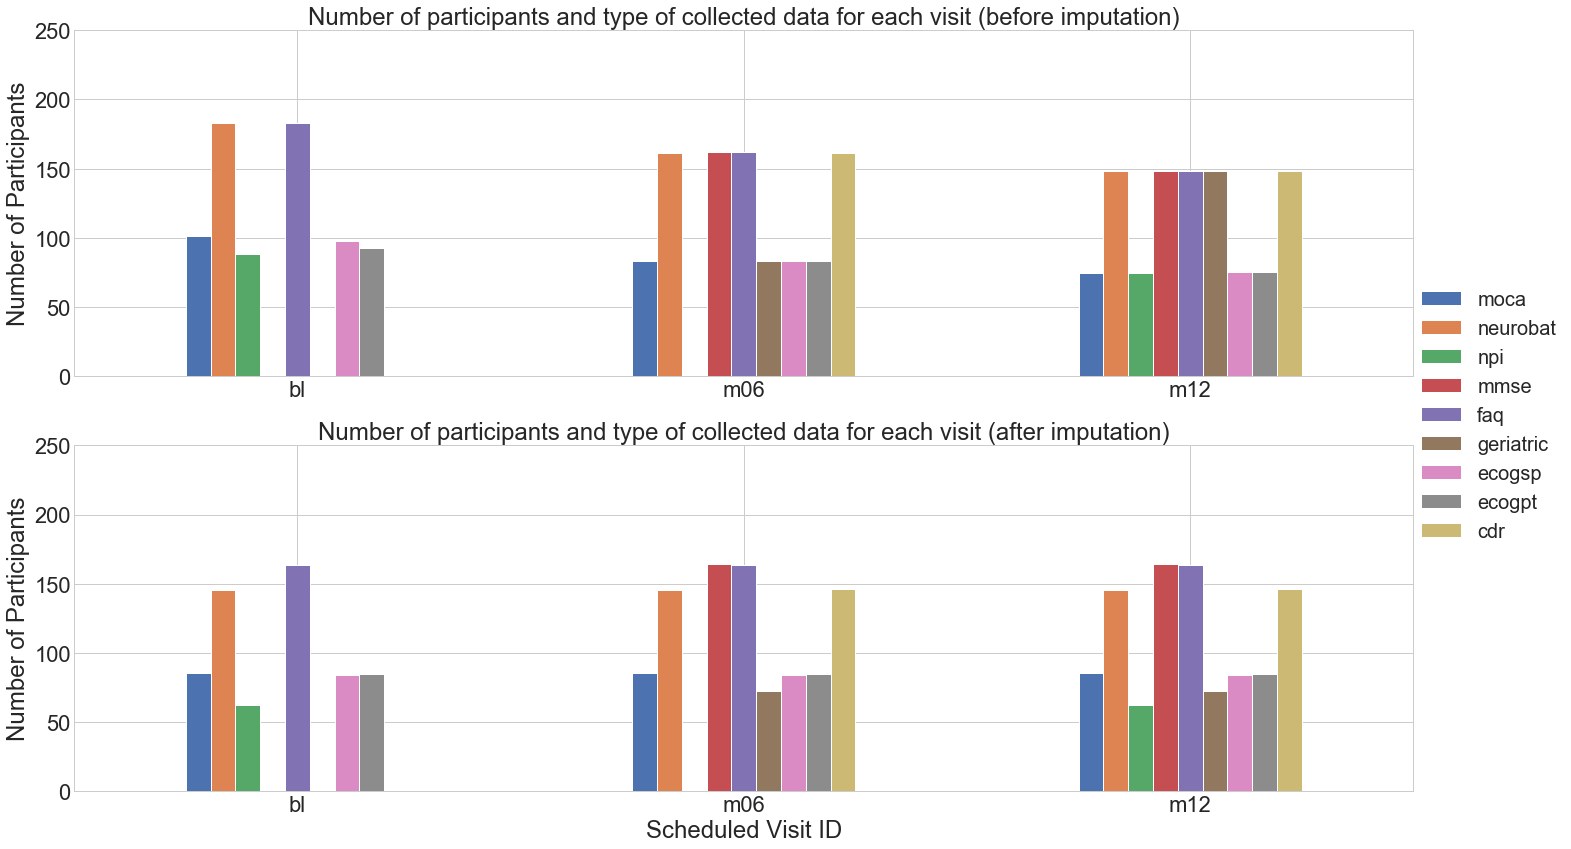

In [16]:
mpl.rc('font', size= 18)
mpl.rc('axes', titlesize= 18)
mpl.style.use('seaborn-whitegrid')
# Data available without imputation
a = moca1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'moca'})
c = neurobat_1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'neurobat'})
d = npi1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'npi'})
f = mmse1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'mmse'})
g = faq1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'faq'})
j = geriatric1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'geriatric'})
k = ecogsp1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'ecogsp'})
l = ecogpt1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'ecogpt'})
m = cdr1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'cdr'})


plot_data = a.merge(c, on='VISCODE2', how='outer').merge(d, on='VISCODE2', how='outer').merge(f, on='VISCODE2', how='outer').merge(g, on='VISCODE2', how='outer').merge(j, on='VISCODE2', how='outer')\
.merge(k, on='VISCODE2', how='outer').merge(l, on='VISCODE2', how='outer').merge(m, on='VISCODE2', how='outer')

plot_data = plot_data[plot_data.VISCODE2.isin(['bl','m06','m12','m18','m36','m48','m24'])]


# Data available after imputation
a2 = moca2.unstack().reset_index().groupby('VISCODE2')['RID'].nunique().reset_index().rename(columns={'RID':'moca'})
c2 = neurobat3.unstack().reset_index().groupby('VISCODE2')['RID'].nunique().reset_index().rename(columns={'RID':'neurobat'})
d2 = npi2.unstack().reset_index().groupby('VISCODE2')['RID'].nunique().reset_index().rename(columns={'RID':'npi'})
f2 = mmse2.unstack().reset_index().groupby('VISCODE2')['RID'].nunique().reset_index().rename(columns={'RID':'mmse'})
g2 = faq2.unstack().reset_index().groupby('VISCODE2')['RID'].nunique().reset_index().rename(columns={'RID':'faq'})
j2 = geriatric2.unstack().reset_index().groupby('VISCODE2')['RID'].nunique().reset_index().rename(columns={'RID':'geriatric'})
k2 = ecogsp2.T.unstack().reset_index().groupby('VISCODE2')['RID'].nunique().reset_index().rename(columns={'RID':'ecogsp'})
l2 = ecogpt2.T.unstack().reset_index().groupby('VISCODE2')['RID'].nunique().reset_index().rename(columns={'RID':'ecogpt'})
m2 = cdr2.unstack().reset_index().groupby('VISCODE2')['RID'].nunique().reset_index().rename(columns={'RID':'cdr'})

plot_data_imp = a2.merge(c2, on='VISCODE2', how='outer').merge(d2, on='VISCODE2', how='outer').merge(f2, on='VISCODE2', how='outer').merge(g2, on='VISCODE2', how='outer')\
.merge(j2, on='VISCODE2', how='outer').merge(k2, on='VISCODE2', how='outer').merge(l2, on='VISCODE2', how='outer').merge(m2, on='VISCODE2', how='outer')

plot_data_imp = plot_data_imp[plot_data_imp.VISCODE2.isin(['bl','m06','m12'])]

f1, ax1 = plt.subplots(1)
plot_data.set_index('VISCODE2').plot(kind='bar', title="Number of participants and type of collected data for each visit (before imputation)", figsize=(20, 8), ax = ax1)
patches, labels = ax1.get_legend_handles_labels()
ax1.legend(patches, labels, bbox_to_anchor=(1.1, 1), loc='upper right', fontsize=12)
ax1.set_ylabel("Number of Participants", fontsize=18);
ax1.set_xlabel("Scheduled Visit ID", fontsize=18);
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize = '16', rotation = 0)
ax1.set_yticklabels( list(range(0,2500,50)) ,fontsize = '16', rotation = 0)
ax1.grid(True)
f1.savefig(address + 'distribution.png', dpi = 200)
f1.show()


f, (ax1, ax2) = plt.subplots(2)
plot_data = plot_data[plot_data.VISCODE2.isin(['bl','m06','m12'])]
plot_data.set_index('VISCODE2').plot(kind='bar', title="Number of participants and type of collected data for each visit (before imputation)", figsize=(24, 14), ax = ax1, legend=False)
patches, labels = ax1.get_legend_handles_labels()
ax1.set_ylabel("Number of Participants", fontsize=24);
ax1.set_xlabel("", fontsize=24);
ax1.set(ylim=(0, 2500))
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize = '22', rotation = 0)
ax1.set_yticklabels( list(range(0,2500,50)) ,fontsize = '22', rotation = 0)
ax1.set_title( label = "Number of participants and type of collected data for each visit (before imputation)", fontsize = '24' )
ax1.grid(True)

plot_data_imp = plot_data_imp[plot_data_imp.VISCODE2.isin(['bl','m06','m12','m24'])]
p = plot_data_imp.set_index('VISCODE2').plot(kind='bar', title="Number of participants and type of collected data for each visit (after imputation)", figsize=(24, 14), ax = ax2)
ax2.legend(patches, labels, bbox_to_anchor=(1.12, 1.5), loc='center middle', fontsize=20)
ax2.set_ylabel("Number of Participants", fontsize=24);
ax2.set_xlabel("Scheduled Visit ID", fontsize=24);
ax2.set(ylim=(0, 2500))
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize = '22', rotation = 0)
ax2.set_yticklabels( list(range(0,2500,50)) ,fontsize = '22', rotation = 0)
ax2.set_title( label = "Number of participants and type of collected data for each visit (after imputation)", fontsize = '24' )
ax2.grid(True)
f.savefig(address +'\\paper_fig\\' + 'dist.png', dpi = 200)
f.show()

plot_data = pd.DataFrame(plot_data)
plot_data_imp = pd.DataFrame(plot_data_imp)

In [17]:
# datasets and visits of interest
# dict_datasets dictionary will contain all the data sets.
# common_rids is a list of all the common ridsin the datset
datasets_of_interest = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric','ecogsp', 'ecogpt', 'cdr' , 'faq' ]
dict_datasets = {}
dict_datasets['moca'] = moca    
dict_datasets['neurobat'] = neurobat    
dict_datasets['npi_all'] = npi_all
dict_datasets['mmse'] = mmse             
dict_datasets['geriatric'] = geriatric   
dict_datasets['ecogsp'] = ecogsp
#dict_datasets['UWNPSYCHSUM_10_27_17'] = uwn
dict_datasets['ecogpt'] = ecogpt
dict_datasets['cdr'] = cdr
dict_datasets['faq'] = faq 
size_matrix = pd.DataFrame(np.zeros((len(dict_datasets),2)) )
for r in range(len(dict_datasets) ):
    size_matrix.iloc[r,0] = datasets_of_interest[r]
    size_matrix.iloc[r,1] = len(dict_datasets[datasets_of_interest[r]])
size_matrix.columns = ['dataset','count']
size_matrix =size_matrix.set_index('dataset')
size_matrix = size_matrix.sort_values(by = ['count'],ascending= False )       
sorted_cols = list(size_matrix.index)
common_rids = pd.DataFrame(np.zeros((len(dict_datasets),len(dict_datasets))))
common_rids.columns = sorted_cols
common_rids.index = sorted_cols
for i in range(len(dict_datasets)):
    for u in range(len(dict_datasets)):
        if (u>=i):
            a = list(dict_datasets[sorted_cols[i]].index)
            b = list(dict_datasets[sorted_cols[u]].index)
        
            common = list(set(a).intersection(b))
            common_rids.iloc[i,u] = len(common)

Max_intersection_dataset_item = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric','ecogsp', 'ecogpt', 'cdr' , 'faq' ]
print('************************')
print('Datasets considered {} :'.format(Max_intersection_dataset_item)  )
print('************************')

************************
Datasets considered ['moca', 'neurobat', 'npi_all', 'mmse', 'geriatric', 'ecogsp', 'ecogpt', 'cdr', 'faq'] :
************************


In [18]:
# Argument Train1 is dta to be normalized. IF argument b is 'z' the z normalization is done otherwise minmax normalization is done.
def normalize(Train1,b):
    col_names = list(Train1.columns)
    Train1 = pd.DataFrame(Train1)
    if (b == 'z'):
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - Train1[col_names[i]].mean(skipna = True)) / Train1[col_names[i]].std(skipna = True)
    else:
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - min(Train1[col_names[i]]) )/ ( max(Train1[col_names[i]] ) - min(Train1[col_names[i]]) )
    return Train1

In [19]:
def project_data(Max_intersection_dataset, visit, list_months_to_be_considered):
    patno_filtered_visited = dict_datasets[Max_intersection_dataset[0]]
    for t in range(len(Max_intersection_dataset)-1):
        patients = dict_datasets[Max_intersection_dataset[t+1]]
        patno_filtered_visited = pd.merge(patno_filtered_visited, patients, left_index = True, right_index = True, how='inner')
        
    M_chosen = normalize(patno_filtered_visited,'m')
    M_chosen = M_chosen.T[ M_chosen.T.isnull().sum(axis = 1)== 0 ].T
    print(M_chosen.shape)
    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    H = model_NMF.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H_T = M_H.T.sort_values(by=[1],ascending=False)
    M_H_T3 = M_H_T
    M_H_T.columns = ['axis 1','axis 2']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+(M_H_T['axis 2'] *0.05) ) else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +(M_H_T['axis 1']*0.05) ) else 'ambigious', axis=1)
    M_H_T2 = M_H_T
    M_H_T.to_csv(address + "NMF_factorize.csv") 
    H = model_NMF3.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H.loc[2] = H[2,:]
    M_H_T = M_H.T.sort_values(by=[2],ascending=False)
    M_H_T.columns = ['axis 1','axis 2', 'axis 3']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+M_H_T['axis 3'] ) else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +M_H_T['axis 3']) else 'axis 3' if (M_H_T['axis 3'] > M_H_T['axis 1'] +M_H_T['axis 2']) else 'ambigious'  , axis=1)
    M_H_T.to_csv(address + "all_3d_list.csv") 
    M_H_T3 = M_H_T
    redued_data = pd.DataFrame(M_W) # this datset contains all the ICA, PCA and NMF vectors
    # plot the dimension reduction color makrked with participants' "categories", and "gender"
    dignosis = pd.read_csv("ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
    dignosis = dignosis[ ~(dignosis['DXCHANGE'].isnull())]
    dignosis = dignosis[ ~(dignosis['DXMDUE'] == 'MCI due to other etiology')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Mildly Confident')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Uncertain')]
    dignosis = dignosis[dignosis['RID'].isin(redued_data.index)]
    dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['VISCODE'] == visit]
    redued = redued_data.merge(dignosis, how = 'inner', left_index = True, right_index = True)
    redued = redued[ ~(redued['DXCHANGE'].isnull())]    
    redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI',                                               'Stable: Dementia', 'Stable: Dementia to Dementia',                                               'Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia',                                               'Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    # Replacing the codes as described earlier
    redued.DXCHANGE = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8],[1,2,3,2,3,3,1,2]) 
    colors_categories = redued.DXCHANGE.replace([1,2,3], ['red', 'blue', 'green'])
    # use this or above 2 lines
    #colors_categories = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8,9,10,11], ['red', 'blue', 'green', 'yellow','purple','pink','black','cyan','magenta','white','firebrick'])
    return redued, colors_categories, M_chosen,dignosis,M_H_T2, M_H_T3

In [20]:
list_months_to_be_considered = ['bl', 'm06','m12']
visits = 'm24'
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(Max_intersection_dataset_item, visits, list_months_to_be_considered)
print('************************')
print('Number of observations :')
print(len(redued_item_24))
print(redued_item_24['DXCHANGE'].value_counts())
print('************************')
colors_categories_item_24_age = colors_categories_item_24.copy()

(582, 213)
************************
Number of observations :
453
2    197
1    170
3     86
Name: DXCHANGE, dtype: int64
************************


In [21]:
#VISUALISATIONS 
cols['adni_merge'] = ['RID', 'VISCODE','COLPROT','AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']
adni_merge = pd.read_csv('ADNI\\Raw_Data\\Demographic_Plots\\ADNIMERGE.csv', usecols=cols['adni_merge'], index_col = ['RID'])

#The patient who visited again and again in different VISCODES, keeping only the first visit
adni_merge = adni_merge.groupby(adni_merge.index).min()
adni_merge_chosen = adni_merge[adni_merge.index.isin(redued_item_24.index)] #CHANGE HERE FOR DIFFERENT DATASETS 

In [22]:
result = pd.concat([adni_merge_chosen, redued_item_24] , axis = 1, ignore_index= False)
age = result.groupby(['PTGENDER'])['AGE'].agg(['mean','std'])
print( age )
print('\n\n')
age = result['AGE'].agg(['mean','std'])
print( age )
print('\n\n')
sex = result.groupby(['PTGENDER'])['AGE'].count()
print( sex )
print(sum(sex))
print('\n\n')
sex = sex *100 / sum(sex)
print(sex)

disease = result.groupby(['DXCHANGE'])['AGE'].agg(['mean','std'])
print( disease )
print('\n\n')

race = result.groupby(['PTRACCAT'])['PTRACCAT'].count()
race = race*100 /sum(race)
print(race)

               mean       std
PTGENDER                     
Female    71.265865  6.907319
Male      73.223265  7.211329



mean    72.324503
std      7.132749
Name: AGE, dtype: float64



PTGENDER
Female    208
Male      245
Name: AGE, dtype: int64
453



PTGENDER
Female    45.916115
Male      54.083885
Name: AGE, dtype: float64
               mean       std
DXCHANGE                     
1         72.844118  6.097016
2         71.614721  7.470974
3         72.923256  8.115239



PTRACCAT
Am Indian/Alaskan     0.220751
Asian                 1.324503
Black                 3.532009
Hawaiian/Other PI     0.220751
More than one         1.103753
White                93.598234
Name: PTRACCAT, dtype: float64


In [23]:
list_months_to_be_considered = ['bl', 'm06','m12']
visits = 'm48'
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(Max_intersection_dataset_item, visits, list_months_to_be_considered)
print('************************')
print('Number of observations :')
print(len(redued_item_24))
print(redued_item_24['DXCHANGE'].value_counts())
print('************************')
colors_categories_item_24_age = colors_categories_item_24.copy()

(582, 213)
************************
Number of observations :
247
1    109
2     98
3     40
Name: DXCHANGE, dtype: int64
************************


In [24]:
#VISUALISATIONS 
cols['adni_merge'] = ['RID', 'VISCODE','COLPROT','AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']
adni_merge = pd.read_csv('ADNI\\Raw_Data\\Demographic_Plots\\ADNIMERGE.csv', usecols=cols['adni_merge'], index_col = ['RID'])

#The patient who visited again and again in different VISCODES, keeping only the first visit
adni_merge = adni_merge.groupby(adni_merge.index).min()
adni_merge_chosen = adni_merge[adni_merge.index.isin(redued_item_24.index)] #CHANGE HERE FOR DIFFERENT DATASETS 

In [25]:
result = pd.concat([adni_merge_chosen, redued_item_24] , axis = 1, ignore_index= False)
age = result.groupby(['PTGENDER'])['AGE'].agg(['mean','std'])
print( age )
print('\n\n')
age = result['AGE'].agg(['mean','std'])
print( age )
print('\n\n')
sex = result.groupby(['PTGENDER'])['AGE'].count()
print( sex )
print(sum(sex))
print('\n\n')
sex = sex *100 / sum(sex)
print(sex)

disease = result.groupby(['DXCHANGE'])['AGE'].agg(['mean','std'])
print( disease )
print('\n\n')

race = result.groupby(['PTRACCAT'])['PTRACCAT'].count()
race = race*100 /sum(race)
print(race)

               mean       std
PTGENDER                     
Female    70.774797  6.855136
Male      72.328226  6.680424



mean    71.554656
std      6.798910
Name: AGE, dtype: float64



PTGENDER
Female    123
Male      124
Name: AGE, dtype: int64
247



PTGENDER
Female    49.797571
Male      50.202429
Name: AGE, dtype: float64
               mean       std
DXCHANGE                     
1         72.172477  6.668192
2         71.362245  6.671844
3         70.342500  7.420308



PTRACCAT
Am Indian/Alaskan     0.404858
Asian                 1.619433
Black                 2.429150
More than one         0.809717
White                94.736842
Name: PTRACCAT, dtype: float64
